In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/titanic/'

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Create Dataset

In [4]:
train = pd.read_csv(f'{PATH}train.csv', low_memory=False)
test = pd.read_csv(f'{PATH}test.csv', low_memory=False)

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
DataFrameSummary(test).summary()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418,418,NaN,NaN,332,418,418,NaN,417,NaN,NaN
mean,1100.5,2.26555,NaN,NaN,30.2726,0.447368,0.392344,NaN,35.6272,NaN,NaN
std,120.81,0.841838,NaN,NaN,14.1812,0.89676,0.981429,NaN,55.9076,NaN,NaN
min,892,1,NaN,NaN,0.17,0,0,NaN,0,NaN,NaN
25%,996.25,1,NaN,NaN,21,0,0,NaN,7.8958,NaN,NaN
50%,1100.5,3,NaN,NaN,27,0,0,NaN,14.4542,NaN,NaN
75%,1204.75,3,NaN,NaN,39,1,0,NaN,31.5,NaN,NaN
max,1309,3,NaN,NaN,76,8,9,NaN,512.329,NaN,NaN
counts,418,418,418,418,332,418,418,418,417,91,418
uniques,418,3,418,2,79,7,8,363,169,76,3


In [7]:
DataFrameSummary(train).summary()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,891,891,NaN,NaN,714,891,891,NaN,891,NaN,NaN
mean,446,0.383838,2.30864,NaN,NaN,29.6991,0.523008,0.381594,NaN,32.2042,NaN,NaN
std,257.354,0.486592,0.836071,NaN,NaN,14.5265,1.10274,0.806057,NaN,49.6934,NaN,NaN
min,1,0,1,NaN,NaN,0.42,0,0,NaN,0,NaN,NaN
25%,223.5,0,2,NaN,NaN,20.125,0,0,NaN,7.9104,NaN,NaN
50%,446,0,3,NaN,NaN,28,0,0,NaN,14.4542,NaN,NaN
75%,668.5,1,3,NaN,NaN,38,1,0,NaN,31,NaN,NaN
max,891,1,3,NaN,NaN,80,8,6,NaN,512.329,NaN,NaN
counts,891,891,891,891,891,714,891,891,891,891,204,889
uniques,891,2,3,891,2,88,7,7,681,248,147,3


After loading the datasets, we'll fill out the missing values in some of the columns. In particular, we'll fill the missing values of age and fair with approximately the mean of those columns.

In [8]:
for df in [train, test]:
    df['Age'] = df['Age'].fillna(30).astype(np.int32)
    df['Fare'] = df['Fare'].fillna(33).astype(np.int32)

We'll also drop the names, since we won't be using them

In [9]:
train = train.drop(['Name', 'Ticket', 'PassengerId'], axis=1)
test_passengers = test.set_index('PassengerId')
test = test.drop(['Name', 'Ticket', 'PassengerId'], axis=1)

Next we'll proceed by turning most of the variables into categorical variables

In [10]:
cat_vars = ['Pclass', 'Sex', 'Cabin', 'Embarked']
cont_vars = ['Age', 'SibSp', 'Parch', 'Fare']

In [11]:
test['Survived'] = 0

In [12]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()

In [13]:
apply_cats(test, train)

Then we use proc_df to scale and do final manipulation of the data

In [14]:
df, y, nas, mapper = proc_df(train, 'Survived', do_scale=True)

In [15]:
df_test, _, nas, mapper = proc_df(test, 'Survived', do_scale=True, mapper=mapper, na_dict=nas)

We set up the validation ids

In [16]:
n = len(list(open(f'{PATH}train.csv')))-1
val_idxs = get_cv_idxs(n)
n

891

# Model

In [17]:
y = y.astype(np.int64)

In [18]:
md = ColumnarModelData.from_data_frame(PATH, val_idxs, df, y, cat_flds=cat_vars, bs=128,
                                       test_df=df_test, is_reg=False, is_multi=False)

In [19]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('Pclass', 4), ('Sex', 3), ('Cabin', 148), ('Embarked', 4)]

In [20]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [80]:
learner = md.get_learner(emb_szs, len(df.columns)-len(cat_vars), 0.04, 2, [100,50], [0.12,0.24], use_bn=True)

In [81]:
lr = 0.001
learner.lr_find()

epoch      trn_loss   val_loss       
    0      0.990735   459.409241



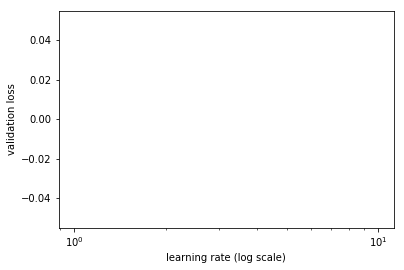

In [82]:
learner.sched.plot()

In [83]:
learner.fit(lr, 5, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy   
    0      0.691672   0.672096   0.601124  
    1      0.674891   0.655684   0.595506  
    2      0.663196   0.642688   0.595506  
    3      0.654347   0.63112    0.595506  
    4      0.64579    0.617446   0.606742  



[0.6174460649490356, 0.6067416071891785]

In [84]:
learner.fit(lr, 5, cycle_len=1, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy   
    0      0.608876   0.610822   0.623596  
    1      0.606175   0.602082   0.662921  
    2      0.601231   0.59383    0.679775  
    3      0.597708   0.585284   0.691011  
    4      0.592552   0.576317   0.696629  



[0.576316773891449, 0.6966292262077332]

In [85]:
learner.fit(lr, 5, cycle_len=3, cycle_mult=2, metrics=[accuracy], best_save_name='best_nn') #This seems to be too much and we end up overfitting

epoch      trn_loss   val_loss   accuracy   
    0      0.566754   0.564824   0.707865  
    1      0.561158   0.555778   0.730337  
    2      0.559618   0.554174   0.730337  
    3      0.555104   0.541281   0.741573  
    4      0.550311   0.529771   0.741573  
    5      0.5457     0.521239   0.752809  
    6      0.538401   0.516134   0.752809  
    7      0.534944   0.513813   0.758427  
    8      0.529849   0.513411   0.758427  
    9      0.525382   0.499785   0.764045  
    10     0.522397   0.48685    0.786517  
    11     0.515256   0.476181   0.792135  
    12     0.509424   0.467211   0.786517  
    13     0.501675   0.460161   0.814607  
    14     0.49533    0.4545     0.820225  
    15     0.485773   0.451494   0.831461  
    16     0.479422   0.448308   0.825843  
    17     0.472988   0.446726   0.825843  
    18     0.46884    0.446098   0.814607  
    19     0.463315   0.445836   0.814607  
    20     0.459527   0.445796   0.814607  
    21     0.455732   0.441677 

[0.5038570165634155, 0.8146067261695862]

## Prediction

In [86]:
learner.load('best_nn')

In [87]:
pred = np.argmax(learner.predict(True), axis=1)

In [88]:
df_pred = pd.DataFrame({'PassengerId':test_passengers.index, 'Survived': pred})

In [89]:
df_pred.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [90]:
df_pred.to_csv(f'{PATH}pred/pred.csv', index=False)
FileLink(f'{PATH}pred/pred.csv')

/home/paperspace/fastai/courses/dl1/data/titanic/pred/pred.csv